# Linear Regression with stratified sampling

Try to apply a linear regression model to the merged otu table

In [1]:
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from src import project_directory
from src.database import get_session, Sample, Dataset

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['H_10_S10_L001' 'H_11_S11_L001' 'H_12_S12_L001' 'H_13_S13_L001'
 'H_14_S14_L001' 'H_15_S15_L001' 'H_16_S16_L001' 'H_17_S17_L001'
 'H_18_S18_L001' 'H_19_S19_L001']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}
sample2dataset = {sample.sample_id: sample.dataset_id for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)
metadata['dataset'] = metadata.index.map(sample2dataset)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[0])

defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7fb9175b59d0>, {'tissue': 'hindgut', 'dataset': 3})


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)
otu_df['dataset'] = otu_df.index.map(sample2dataset)

Inspect the created dataframe:

In [8]:
# collect unique tissue-dataset pairs
tissue_dataset_table = otu_df[['tissue', 'dataset']].drop_duplicates().sort_values(['tissue', 'dataset'])
tissue_dataset_table.reset_index(drop=True)


,tissue,dataset
0,gut,18
1,hindgut,3
2,hindgut,13
3,milk,15
4,milk,16
5,rumen,2
6,rumen,14
7,rumen,47


Simply count how many samples per tissue we have:

In [9]:
otu_df["tissue"].value_counts()

tissue
milk       379
gut        296
rumen      168
hindgut    141
Name: count, dtype: int64

Transform tables:

In [10]:
groups = otu_df["dataset"]
X = otu_df.drop(columns=["tissue", "dataset"])
y = otu_df["tissue"]

So the point is that we have 8 datasets for 4 tissues: if I simply divide the dataset using `train_test_split, I will have in test set samples from the same dataset of the training set: this could be a data leakage. So let's try to split the dataset in
order to not have samples in the test set from the same dataset of the training set:

In [11]:
gss = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

A test of groups:

In [12]:
train_groups = []
test_groups = []

for group in set(groups.iloc[train_idx]):
    group = int(group)
    dataset = session.query(Dataset).filter(Dataset.id == group).one()
    train_groups.append((group, dataset.tissue, dataset.project))
print("train groups:", train_groups)

for group in set(groups.iloc[test_idx]):
    group = int(group)
    dataset = session.query(Dataset).filter(Dataset.id == group).one()
    test_groups.append((group, dataset.tissue, dataset.project))
print("test groups:", test_groups)


train groups: [(18, 'gut', 'INDIGO'), (13, 'hindgut', 'RABOLA'), (14, 'rumen', 'RABOLA'), (15, 'milk', 'RABOLA')]
test groups: [(16, 'milk', 'RABOLA'), (2, 'rumen', 'FARM-INN'), (3, 'hindgut', 'FARM-INN'), (47, 'rumen', '')]


Ok, now create train and test set relyin on indexes:

In [13]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

## Creating a model

In [14]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [15]:
model = LogisticRegression(solver="liblinear", max_iter=1000)
ovr_classifier = OneVsRestClassifier(model)

In [16]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [17]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, verbose=1, cv=5)

In [18]:
grid_search.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [19]:
grid_search.best_params_

{'C': 10, 'penalty': 'l1'}

In [20]:
y_pred = grid_search.predict(scaled_X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.41975308641975306
Classification Report:
              precision    recall  f1-score   support

         gut       0.00      0.00      0.00         0
     hindgut       0.88      0.64      0.74        56
        milk       0.92      0.14      0.24       160
       rumen       1.00      0.72      0.84       108

    accuracy                           0.42       324
   macro avg       0.70      0.38      0.46       324
weighted avg       0.94      0.42      0.53       324



/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` pa

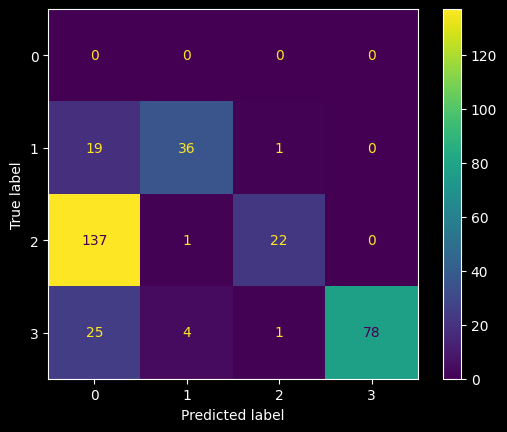

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

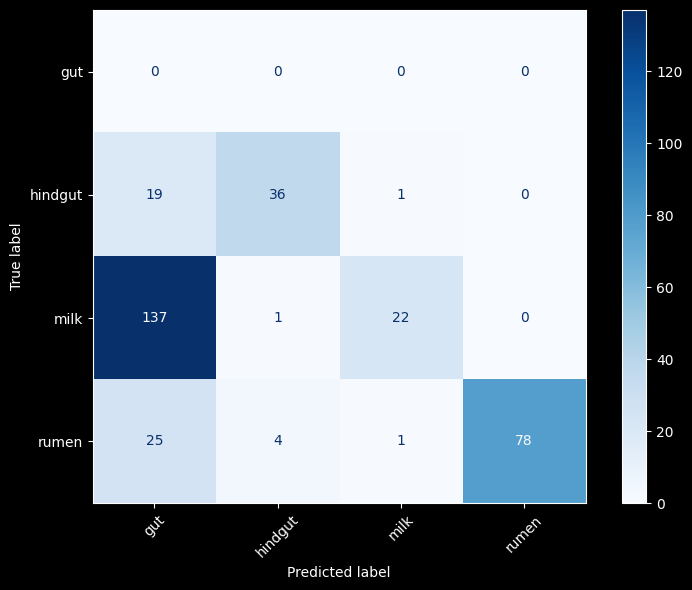

In [23]:
# fallback: unione ordinata di y_true e y_pred per garantire tutte le etichette
class_names = np.unique(np.concatenate([y_test.astype(str), y_pred.astype(str)]))

# Ricomponi la confusion matrix usando le etichette testuali e visualizza
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", values_format='d')
plt.tight_layout()
plt.show()

Get the best model and save it to a file:

In [24]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [25]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
e07b5162b4ea42a9c59f5e7b50061916,-0.357826,0.357826
df3d6113f855e22f2a6d44e60f01baa7,-0.285654,0.285654
5a8d16061b8046cb12fea1106a6f4fd3,-0.280107,0.280107
d68ce1ee602aa886d34ef344207522ab,-0.270686,0.270686
86766dd738309a43aa778842fe8738a7,-0.264291,0.264291
89e81c4eaa9a8f0c1b829936c1e004f1,-0.252712,0.252712
47077b5b0b09ae34e3eee37f67a76d98,0.240142,0.240142
c4e78695dd870f573f6c3a2cb32afaa3,-0.218527,0.218527
3023410abfc23a27539c6617149f35f8,-0.206935,0.206935


try to load the taxononies from file

In [26]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000b0dfd1e9fb1b144a521a5d59c29c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
0001caade39e8c23666cfaefa5b5543c,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,,


In [27]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
e07b5162b4ea42a9c59f5e7b50061916,-0.357826,0.357826,Bacteria,Firmicutes,Bacilli,Bacillales,Marinococcaceae,,,
df3d6113f855e22f2a6d44e60f01baa7,-0.285654,0.285654,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Peptostreptococcaceae,Romboutsia,ilealis,
5a8d16061b8046cb12fea1106a6f4fd3,-0.280107,0.280107,Bacteria,Firmicutes,Bacilli,Bacillales,Marinococcaceae,Alteribacillus,,
d68ce1ee602aa886d34ef344207522ab,-0.270686,0.270686,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Prauserella,aidingensis,
86766dd738309a43aa778842fe8738a7,-0.264291,0.264291,Bacteria,Firmicutes,Clostridia,Oscillospirales,Oscillospiraceae,NK4A214 group,,
